In [ ]:
import pandas as pd

county_data_2023 = pd.read_csv("/content/ZipCodeToCounty.csv")  # Dataset 1
vehicle_data = pd.read_csv("/content/ElectricVehicles2023.csv") # Dataset 2
vehicles_by_zip = vehicle_data.groupby("ZIP")["Number of Vehicles"].sum().reset_index()

In [ ]:
merged = pd.merge(county_data_2023, vehicles_by_zip, on="ZIP", how="outer", indicator=True)

# Count the number of unmatched rows
num_unmatched = (merged["_merge"] != "both").sum()
print(f"Number of ZIPs that didn't match: {num_unmatched}")

Number of ZIPs that didn't match: 255


In [ ]:
merged["EVs per Capita"] = merged["Number of Vehicles"] / merged["ZIP Code Population"]
merged = merged[merged["County"].notna()]
merged

,ZIP,USPS Default State for ZIP,County,ZIP Code Population,Number of Vehicles,_merge,EVs per Capita
1,90001,CA,Los Angeles County,56403.0,305.0,both,0.005408
2,90002,CA,Los Angeles County,52735.0,268.0,both,0.005082
3,90003,CA,Los Angeles County,71708.0,337.0,both,0.004700
4,90004,CA,Los Angeles County,58844.0,1802.0,both,0.030623
5,90005,CA,Los Angeles County,38747.0,1062.0,both,0.027409
...,...,...,...,...,...,...,...
2669,96158,CA,El Dorado County,NaN,16.0,both,NaN
2670,96160,CA,Nevada County,NaN,22.0,both,NaN
2671,96161,CA,Nevada County,19231.0,747.0,both,0.038844
2672,96161,CA,Placer County,19231.0,747.0,both,0.038844


In [ ]:
# Normalize both columns
merged["County"] = merged["County"].str.replace(" County", "", regex=False)

# Drop any already-merged versions of the columns
merged = merged.drop(columns=["Population", "ZEV Sales"], errors="ignore")

# Merge on the "County" column
county_data_2023 = county_data_2023.rename(columns={"COUNTY": "County"})

In [ ]:
# Delete unecessary columns
merged.drop(columns=["USPS Default State for ZIP", "_merge"], inplace=True)
merged.head()

,ZIP,County,ZIP Code Population,Number of Vehicles,EVs per Capita
1,90001,Los Angeles,56403.0,305.0,0.005408
2,90002,Los Angeles,52735.0,268.0,0.005082
3,90003,Los Angeles,71708.0,337.0,0.004700
4,90004,Los Angeles,58844.0,1802.0,0.030623
5,90005,Los Angeles,38747.0,1062.0,0.027409


In [ ]:
# Remove zip codes below a population threshold (100 residents)
merged = merged[merged["ZIP Code Population"] > 100]

In [ ]:
# Compute county-level weighted average
county_weighted_avg = (
    merged.dropna(subset=["ZIP Code Population", "Number of Vehicles"])
          .groupby("County", group_keys=False)
          .apply(lambda g: g["Number of Vehicles"].sum() / g["ZIP Code Population"].sum())
          .reset_index(name="County_EVs_per_Capita")
)

merged = merged.drop(columns=["County_EVs_per_Capita"], errors="ignore")
merged = merged.merge(county_weighted_avg, on="County", how="left")

# Compare using correct column name
merged["Below Average"] = merged["EVs per Capita"] < 0.8 * merged["County_EVs_per_Capita"]

print("County-Level EVs per Capita")
print(county_weighted_avg.sort_values("County_EVs_per_Capita", ascending=False).head(10))

County-Level EVs per Capita
           County  County_EVs_per_Capita
40      San Mateo               0.072428
20          Marin               0.071674
42    Santa Clara               0.069712
0         Alameda               0.061531
6    Contra Costa               0.056550
29         Orange               0.056359
37  San Francisco               0.043814
55        Ventura               0.040568
36      San Diego               0.040195
30         Placer               0.040060


<ipython-input-24-b54a12d8ced0>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["Number of Vehicles"].sum() / g["ZIP Code Population"].sum())


In [ ]:
# Disparity metrics

merged["Adoption Gap"] = merged["County_EVs_per_Capita"] - merged["EVs per Capita"]
merged["Adoption Ratio"] = merged["EVs per Capita"] / merged["County_EVs_per_Capita"]

In [ ]:
print("ZIPs with Largest Absolute Gaps")
print(
    merged.sort_values("Adoption Gap", ascending=False)[
        ["ZIP", "County", "EVs per Capita", "County_EVs_per_Capita", "Adoption Gap", "ZIP Code Population"]
    ].head(10)
)

print("ZIPs with Largest Relative Gaps (Lowest Ratios)")
print(
    merged[merged["County_EVs_per_Capita"] > 0]  # Avoid divide-by-zero
    .sort_values("Adoption Ratio")[
        ["ZIP", "County", "EVs per Capita", "County_EVs_per_Capita", "Adoption Ratio", "ZIP Code Population"]
    ].head(10)
)

ZIPs with Largest Absolute Gaps
        ZIP        County  EVs per Capita  County_EVs_per_Capita  \
1245  94964         Marin        0.005201               0.071674   
1208  94720       Alameda        0.000885               0.061531   
1099  94514       Alameda        0.004892               0.061531   
1157  94575  Contra Costa        0.000995               0.056550   
1294  95076   Santa Clara        0.015763               0.069712   
1182  94603       Alameda        0.009687               0.061531   
1098  94514  Contra Costa        0.004892               0.056550   
1032  94060     San Mateo        0.021598               0.072428   
1299  95116   Santa Clara        0.019789               0.069712   
1195  94621       Alameda        0.012205               0.061531   

      Adoption Gap  ZIP Code Population  
1245      0.066473               2115.0  
1208      0.060646               5649.0  
1099      0.056639               2044.0  
1157      0.055555               1005.0  
1294     

Top 10 Counties by Standard Deviation in EV Adoption Across ZIPs
County
San Francisco    0.075302
San Mateo        0.043115
Los Angeles      0.040744
Santa Clara      0.037492
Orange           0.037020
Contra Costa     0.036924
Alameda          0.035489
San Diego        0.033559
Marin            0.029069
Ventura          0.027764
Name: EVs per Capita, dtype: float64


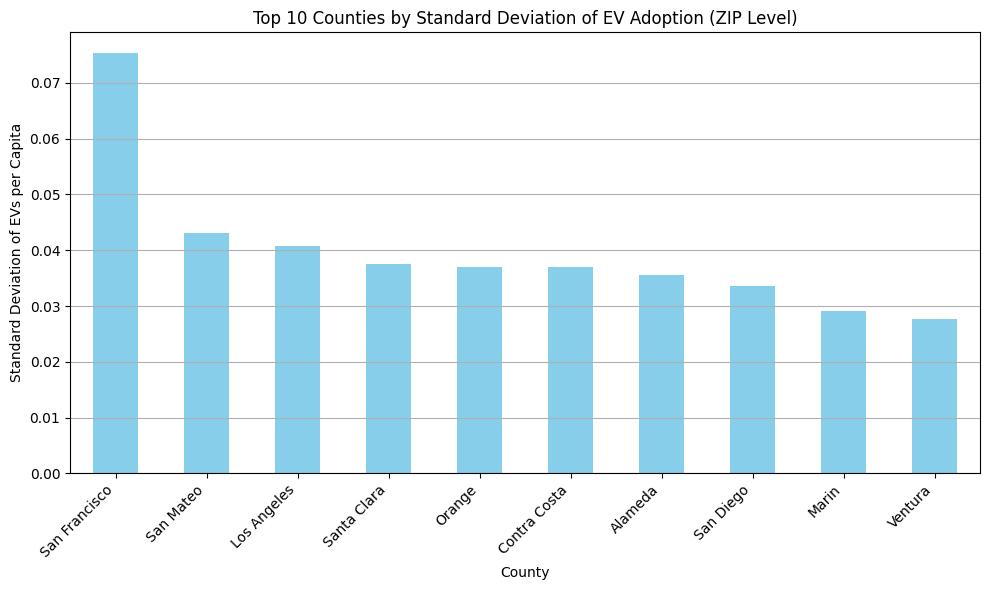

In [ ]:
# Plot Figure 1

import matplotlib.pyplot as plt

# Calculate standard deviation of EV adoption within each county
county_std = (
    merged.groupby("County")["EVs per Capita"]
    .std()
    .sort_values(ascending=False)
    .dropna()
)

# View top counties by internal disparity
print("Top 10 Counties by Standard Deviation in EV Adoption Across ZIPs")
print(county_std.head(10))

# Plot the top 10
top_std = county_std.head(10)

plt.figure(figsize=(10, 6))
top_std.plot(kind="bar", color="skyblue")
plt.title("Top 10 Counties by Standard Deviation of EV Adoption (ZIP Level)")
plt.ylabel("Standard Deviation of EVs per Capita")
plt.xlabel("County")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [ ]:
# Z-score Outlier Detection (Per County)
# Which ZIPs are statistical outliers within their county?

merged["County_Mean"] = merged.groupby("County")["EVs per Capita"].transform("mean")
merged["County_Std"] = merged.groupby("County")["EVs per Capita"].transform("std")
merged["Z_Score"] = (merged["EVs per Capita"] - merged["County_Mean"]) / merged["County_Std"]

# Flag ZIPs with Z-score > 2 or < -2
outliers = merged[merged["Z_Score"].abs() > 2]
print(outliers[["ZIP", "County", "EVs per Capita", "Z_Score"]])

        ZIP       County  EVs per Capita   Z_Score
8     90010  Los Angeles        0.133542  2.096752
42    90045  Los Angeles        0.297625  6.123928
57    90067  Los Angeles        0.219273  4.200908
62    90077  Los Angeles        0.169282  2.973937
66    90210  Los Angeles        0.145634  2.393539
...     ...          ...             ...       ...
1772  95973       Tehama        0.016168  2.716006
1779  95983       Plumas        0.019444  2.269819
1801  96017       Shasta        0.022727  2.496296
1808  96024      Trinity        0.012634  2.230916
1842  96067     Siskiyou        0.016923  2.361148

[91 rows x 4 columns]


In [ ]:
# Underperformers: More than 2 std dev below county average
underperformers = merged[merged["Z_Score"] < -2]

# Overperformers: More than 2 std dev above county average
overperformers = merged[merged["Z_Score"] > 2]

# Only look at top 10 underperformers and overperformers
top_under = underperformers.sort_values("Z_Score").head(10)
top_over = overperformers.sort_values("Z_Score", ascending=False).head(10)
top_under["Category"] = "Underperformer"
top_over["Category"] = "Overperformer"
top_outliers_combined = pd.concat([top_under, top_over])
print(top_outliers_combined)

        ZIP         County  ZIP Code Population  Number of Vehicles  \
1245  94964          Marin               2115.0                11.0   
42    90045    Los Angeles              42352.0             12605.0   
1047  94104  San Francisco                478.0               205.0   
101   90301    Los Angeles              36428.0              8702.0   
861   93531           Kern                497.0                28.0   
1445  95391    San Joaquin              25193.0              3062.0   
980   93730         Fresno              13021.0               877.0   
378   92067      San Diego               8245.0              1561.0   
389   92091      San Diego               1215.0               226.0   
106   90401    Los Angeles               7925.0              1776.0   
1131  94550     Stanislaus              49610.0              2807.0   

      EVs per Capita  County_EVs_per_Capita  Below Average  Adoption Gap  \
1245        0.005201               0.071674           True      0.06647

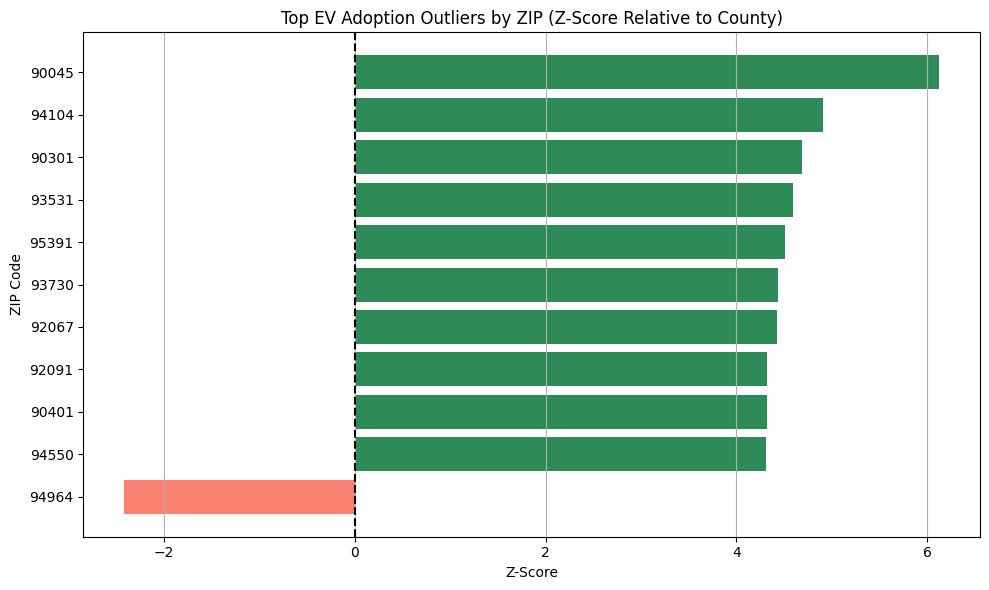

In [ ]:
# Plot Figure 2

# Sort so underperformers appear at bottom
combined = top_outliers_combined.sort_values("Z_Score")

plt.figure(figsize=(10, 6))
bars = plt.barh(combined["ZIP"].astype(str), combined["Z_Score"], color=combined["Category"].map({"Underperformer": "salmon", "Overperformer": "seagreen"}))
plt.axvline(0, color="black", linestyle="--")
plt.title("Top EV Adoption Outliers by ZIP (Z-Score Relative to County)")
plt.xlabel("Z-Score")
plt.ylabel("ZIP Code")
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()

In [ ]:
# Plot Figure 3

import plotly.express as px

# Filter to only rows with complete data
filtered = merged.dropna(subset=["County_EVs_per_Capita", "EVs per Capita", "ZIP"])

# Create interactive scatter plot with hover info
fig = px.scatter(
    filtered,
    x="County_EVs_per_Capita",
    y="EVs per Capita",
    color="County",
    hover_name="ZIP",
    hover_data={"County": True, "ZIP Code Population": True},
    labels={
        "County_EVs_per_Capita": "County EVs per Capita",
        "EVs per Capita": "ZIP EVs per Capita"
    },
    title="ZIP vs County EV Adoption Rates (Interactive)"
)

# Add diagonal reference line (y = x)
fig.add_shape(
    type="line",
    x0=0, y0=0,
    x1=filtered["County_EVs_per_Capita"].max(),
    y1=filtered["County_EVs_per_Capita"].max(),
    line=dict(color="red", dash="dash")
)

fig.update_layout(height=800, width=800)
fig.show()